# Daily temperatures in London, 2005-2015

The plot at the end shows below:

1. A line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Leap days (i.e. February 29th) are excluded for the purpose of visualisation.

In [1]:
%matplotlib -l

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'inline', 'ipympl', 'widget']


In [2]:
%matplotlib notebook

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.read_csv('data/london-daily-weather.csv').dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67648 entries, 0 to 67647
Data columns (total 4 columns):
ID            67648 non-null object
Date          67648 non-null object
Element       67648 non-null object
Data_Value    67648 non-null int64
dtypes: int64(1), object(3)
memory usage: 2.6+ MB


In [4]:
# Remove leap days i.e. feb 29th

df = df[~df['Date'].str.contains('02-29')]

# Convert date to datetime

df['Date'] = pd.to_datetime(df['Date'])

# Convert value to degrees celcius

df['Data_Value'] = df['Data_Value'].apply(lambda x: x * 0.1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67614 entries, 0 to 67647
Data columns (total 4 columns):
ID            67614 non-null object
Date          67614 non-null datetime64[ns]
Element       67614 non-null object
Data_Value    67614 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.6+ MB


In [5]:
# Filter datasets for 2005-2014

years_filter = (df['Date'].dt.year >= 2005) & (df['Date'].dt.year <= 2014)

period_df = df[years_filter]

In [6]:
# Create a dataframe for record lows

min_df = period_df[period_df['Element'] == 'TMIN']

min_df = (min_df
          .groupby([period_df['Date'].dt.month, period_df['Date'].dt.day])
          .agg({'Data_Value': np.min}))

In [7]:
# Create a dataframe for record highs

max_df = period_df[period_df['Element'] == 'TMAX']

max_df = (max_df
          .groupby([period_df['Date'].dt.month, period_df['Date'].dt.day])
          .agg({'Data_Value': np.max}))

In [8]:
record_temp_df = (pd
           .merge(min_df, max_df, left_index=True, right_index=True)
           .rename(columns={'Data_Value_x': 'MIN', 'Data_Value_y': 'MAX'}))

record_temp_df.head()

MIN   MAX
Date Date           
1    1    -3.4  13.0
     2    -4.3  11.3
     3    -6.9  12.6
     4    -7.6  11.7
     5    -8.0  12.2

In [9]:
# Create datetime index for plotting

import datetime

# Using the MultiIndex, constructing datetime for non-leap year

new_index = [pd.to_datetime('2009-{}-{}'.format(date[0], date[1])) for date in record_temp_df.index]

record_temp_df['new_index'] = new_index

record_temp_df = record_temp_df.reset_index(drop=True).set_index('new_index')

record_temp_df.head()

,MIN,MAX
new_index,,
2009-01-01,-3.4,13.0
2009-01-02,-4.3,11.3
2009-01-03,-6.9,12.6
2009-01-04,-7.6,11.7
2009-01-05,-8.0,12.2


In [10]:
# Extract dataset for 2015

latest_df = df[df['Date'].dt.year == 2015]

In [11]:
# Create a dataframe for record lows in 2015

latest_min_df = latest_df[latest_df['Element'] == 'TMIN']

latest_min_df = (latest_min_df
                 .groupby([latest_df['Date'].dt.month, latest_df['Date'].dt.day])
                 .agg({'Data_Value': np.min}))

In [12]:
# Create a dataframe for record highs in 2015

latest_max_df = latest_df[latest_df['Element'] == 'TMAX']

latest_max_df = (latest_max_df
                 .groupby([latest_df['Date'].dt.month, latest_df['Date'].dt.day])
                 .agg({'Data_Value': np.max}))

In [13]:
# Merge lows & highs and convert index to datetime

latest_temp_df = (pd
                  .merge(latest_min_df, latest_max_df, left_index=True, right_index=True)
                  .rename(columns={'Data_Value_x': '2015_min', 'Data_Value_y': '2015_max'}))

latest_temp_df['new_index'] = new_index

latest_temp_df = latest_temp_df.reset_index(drop=True).set_index('new_index')

latest_temp_df.head()

,2015_min,2015_max
new_index,,
2009-01-01,2.9,10.8
2009-01-02,5.9,11.4
2009-01-03,0.9,8.2
2009-01-04,-1.4,8.6
2009-01-05,-1.1,10.0


In [14]:
# Merge record_temp_df and latest_temp_df

merged_df = pd.merge(record_temp_df, 
                     latest_temp_df, 
                     left_index=True, 
                     right_index=True)

merged_df.head()

,MIN,MAX,2015_min,2015_max
new_index,,,,
2009-01-01,-3.4,13.0,2.9,10.8
2009-01-02,-4.3,11.3,5.9,11.4
2009-01-03,-6.9,12.6,0.9,8.2
2009-01-04,-7.6,11.7,-1.4,8.6
2009-01-05,-8.0,12.2,-1.1,10.0


In [15]:
# for 2015 columns, only keep if it's lower (for min) or higher (for max) than the record low/high

def foo(entry):
    if entry['2015_min'] >= entry['MIN']:
        entry['2015_min'] = None
    
    if entry['2015_max'] <= entry['MAX']:
        entry['2015_max'] = None

    return entry    

merged_df = merged_df.apply(foo, axis=1)

merged_df.head()

,MIN,MAX,2015_min,2015_max
new_index,,,,
2009-01-01,-3.4,13.0,NaN,NaN
2009-01-02,-4.3,11.3,NaN,11.4
2009-01-03,-6.9,12.6,NaN,NaN
2009-01-04,-7.6,11.7,NaN,NaN
2009-01-05,-8.0,12.2,NaN,NaN


<IPython.core.display.Javascript object>


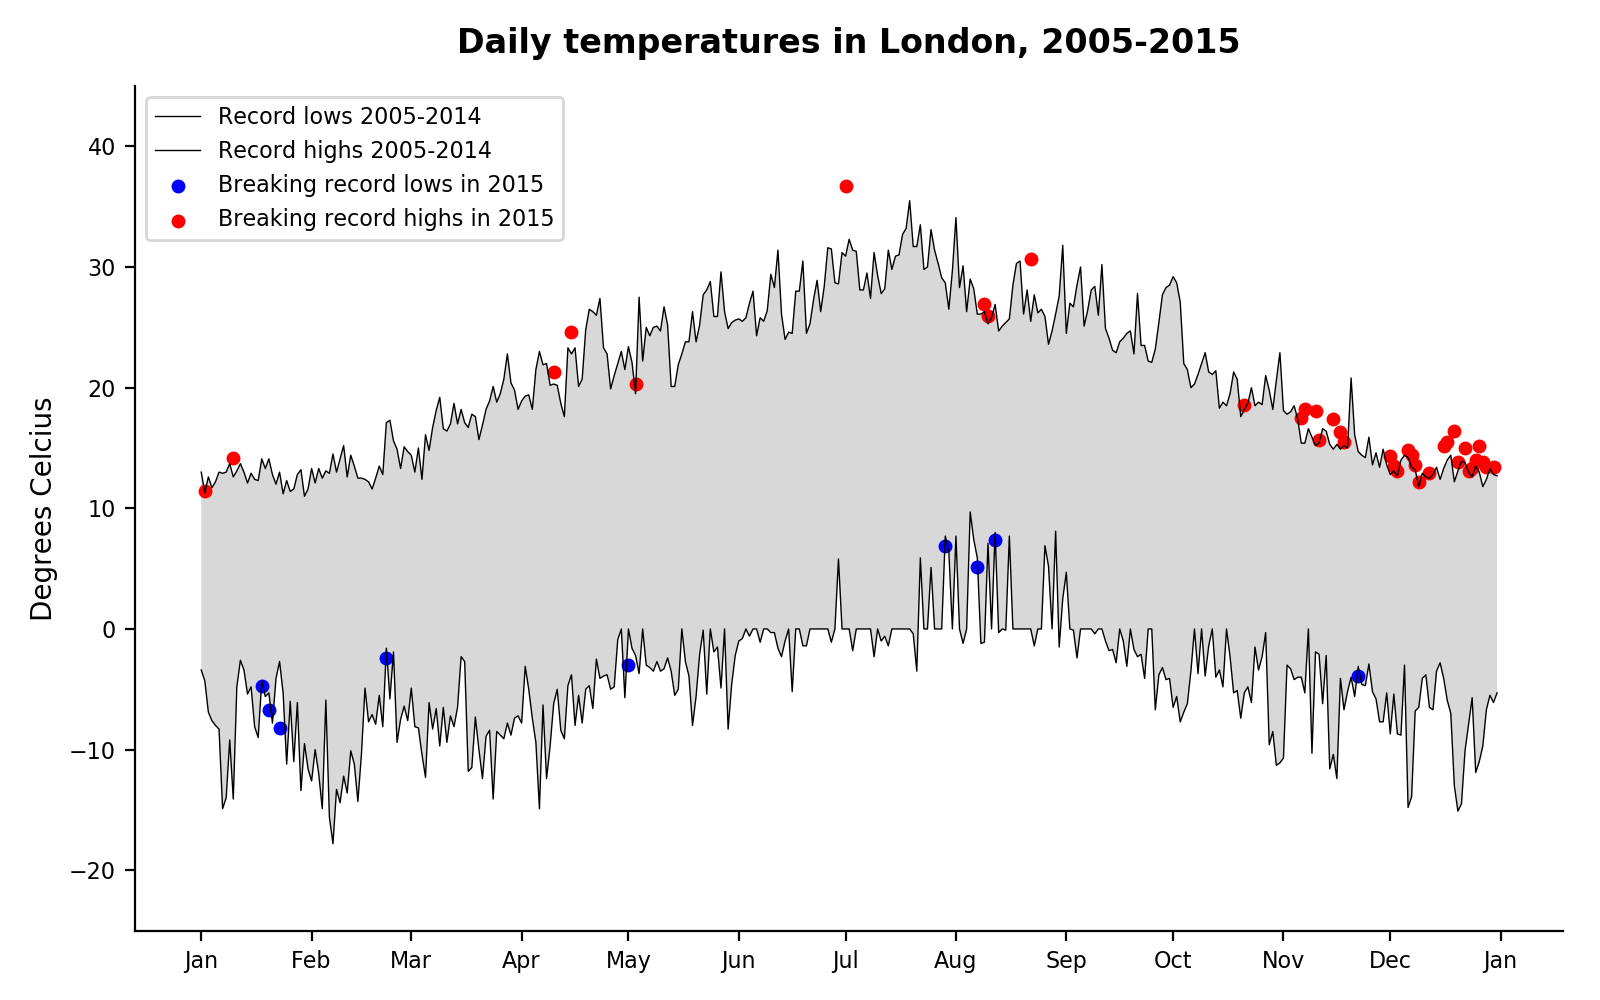

In [16]:
# Set params for the plot

plt.rcParams['lines.markersize'] = 4

# Create a plot

fig = plt.figure(figsize=(8,5))

ax = fig.add_subplot(111)

# Plot record lows & highs 2005-2014

ax.plot_date(record_temp_df.index, 
             list(record_temp_df['MIN']), 
             '-', color='k', 
             linewidth=0.5, 
             label='Record lows 2005-2014')

ax.plot_date(record_temp_df.index, 
             list(record_temp_df['MAX']), 
             '-', 
             color='k', 
             linewidth=0.5, 
             label='Record highs 2005-2014')

# Fill the gap between

ax.fill_between(record_temp_df.index, 
                record_temp_df['MIN'], 
                record_temp_df['MAX'], 
                facecolor='grey', 
                alpha=0.3)

In [17]:
# Plot the breaking lows and highs from 2015 datapoints

ax.scatter(merged_df.index, 
           merged_df['2015_min'], 
           color='b', 
           label='Breaking record lows in 2015')

ax.scatter(merged_df.index, 
           merged_df['2015_max'], 
           color='r', 
           label='Breaking record highs in 2015')

In [18]:
# Format x axis to display only months

from matplotlib.dates import MonthLocator, DateFormatter

months = MonthLocator(range(1, 13))
monthsFmt = DateFormatter('%b')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)

In [19]:
# Format title

ax.set_title('Daily temperatures in London, 2005-2015', 
             fontsize=12, 
             fontweight='bold')

ttl = ax.title
ttl.set_position([.5, 1.02])

# Format y axis

ax.set_ylim(-25, 45)
ax.set_ylabel('Degrees Celcius')

# Format labels

ax.tick_params(axis='both', which='major', labelsize=8)

# Add legend

ax.legend(loc='upper left', fontsize=8)

# Remove unnecessary frames

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Save an image

plt.tight_layout()
plt.savefig('./graphs/daily-temps-london-2005-2015.png',
            bbox_inches='tight',
            dpi=300)